<a href="https://colab.research.google.com/github/morteza-sakifard/ML-Classifier/blob/main/Gaussian_Distributed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maximum Likelihood Classifier
The main idea of Maximum Likelihood (ML) Classifier is to predict the class label y that maximizes the likelihood of our observed data x. We will consider x as being a random vector and y as being a parameter (not random) on which the distribution of x depends. At first, we need to make an assumption about the distribution of x (usually a **Gaussian distribution**).

In [ ]:
import numpy as np
import pandas as pd

## Train Model
Then, the learning of our data consists of the following:   
*   We split our dataset into subsets corresponding to each label y.
*   For each subset, we estimate the parameters of our assumed distribution for x using only the data inside that subset.

In [ ]:
def train_model(dataset):
  grouped = dataset.groupby(['Class'])
  feature_columns = dataset.columns[dataset.columns != 'Class']
  params = dict()
  for name, group in grouped:
    samples = group[feature_columns]
    params[name] = {'cov': samples.cov(), 'mean': samples.mean()}
  return params

## Classifier
When making a prediction on a new data vector x:
*   We evaluate the PDF of our assumed distribution using our estimated parameters for each label y.
*   Return the label y for which the evaluated PDF had the maximum value.

In [ ]:
def classify(dataset, params):
  predicted_labels = np.empty(len(dataset))
  for index, row in dataset.iterrows(): 
    classifieds = list()
    for idx, param in params.items():
      likelihood = get_likelihood(row, len(dataset.columns), param['mean'], param['cov'])
      classifieds.append(likelihood)
    ml_index = np.argmax(classifieds)
    predicted_label = ml_index + 1
    predicted_labels[index] = predicted_label
  return predicted_labels

## Multivariate Gaussian Distribution

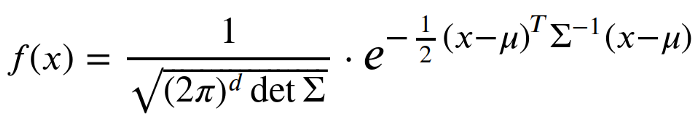
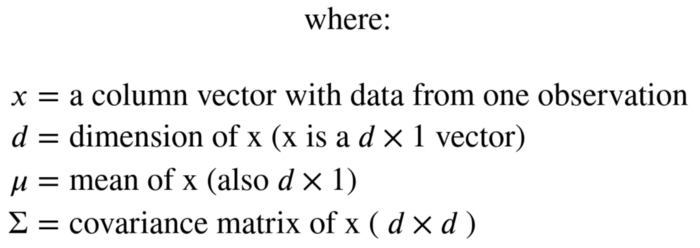

In [ ]:
def get_likelihood(x, n_features, mean, cov):
  return np.power(2 * np.pi, n_features * -.5) * np.power(np.linalg.det(cov), -.5) * np.exp((-.5) * (x - mean).T @ np.linalg.inv(cov) @ (x - mean))

## Confusion Matrix
A confusion matrix is a summary of prediction results on a classification problem.

The number of correct and incorrect predictions are summarized with count values and broken down by each class. 

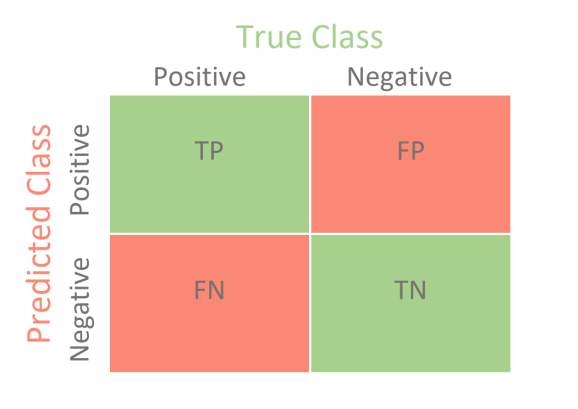

In [ ]:
def get_confusion_matrix(class_labels, predicted_labels):
  labels = class_labels.unique()
  confusion_matrix = dict()
  for class_label in labels:
    p_labels = predicted_labels[class_labels == class_label]
    confusion_matrix[class_label] = list()
    for predicted_label in labels:
      confusion_matrix[class_label].append((p_labels == predicted_label).sum())
  return pd.DataFrame(confusion_matrix, index=range(1, len(labels) + 1))

In [ ]:
#return accuracy of classifier [Total, Class 1, Class 2, ...]
def evaluate_model(confusion_matrix):
  accuracy = [np.diag(confusion_matrix).sum() / confusion_matrix.sum().sum()]
  for label in range(1, confusion_matrix.shape[0] + 1):
    accuracy.append(confusion_matrix[label][label] / confusion_matrix[label].sum())
  return accuracy

# Dataset 
4 classes with 5 features that are normally distributed 

In [ ]:
dataset = pd.read_csv('/Dataset/dataset.txt', sep='	', header=None)
dataset.columns = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Class']
dataset.head()

,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Class
0,0.08,0.08,0.10,0.24,0.90,1
1,0.06,0.06,0.05,0.25,0.33,2
2,0.10,0.10,0.15,0.65,0.30,3
3,0.08,0.08,0.08,0.98,0.24,2
4,0.09,0.15,0.40,0.10,0.66,3


In [ ]:
print(f'Dataset {dataset.shape}')
grouped = dataset.groupby('Class')
for name, group in grouped:
  print(f'Class {name}', f'Samples {len(group)}')

Dataset (257, 6)
Class 1 Samples 63
Class 2 Samples 83
Class 3 Samples 88
Class 4 Samples 23


## Train & Classification


In [ ]:
train = pd.DataFrame(columns = dataset.columns.to_list())
test = pd.DataFrame(columns = dataset.columns.to_list())
for name, group in grouped:
  test_df = group.sample(frac=0.2)
  train_df = group[~group.index.isin(test_df.index)]
  test = test.append(test_df, ignore_index=True)
  train = train.append(train_df, ignore_index=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
print(f'Train Dataset {train.shape}')
for name, group in train.groupby('Class'):
  print(f'Class {name}', f'Samples {len(group)}')

Train Dataset (204, 6)
Class 1 Samples 50
Class 2 Samples 66
Class 3 Samples 70
Class 4 Samples 18


In [ ]:
print(f'Test Dataset {test.shape}')
for name, group in test.groupby('Class'):
  print(f'Class {name}', f'Samples {len(group)}')

Test Dataset (53, 6)
Class 1 Samples 13
Class 2 Samples 17
Class 3 Samples 18
Class 4 Samples 5


In [ ]:
params = train_model(train)

In [ ]:
feature_columns = test.columns[test.columns != 'Class']
samples = test.loc[:, feature_columns]
predicted_labels = classify(samples, params)

## Confustion Matrix

In [ ]:
confusion_matrix = get_confusion_matrix(test['Class'], predicted_labels)
print('Rows is predicted labels and Columns is true labels')
confusion_matrix

Rows is predicted labels and Columns is true labels


,1,2,3,4
1,13,0,2,0
2,0,16,2,0
3,0,0,14,0
4,0,1,0,5


In [ ]:
accuracies = evaluate_model(confusion_matrix)
print(f'Total Accuracy {accuracies[0]:.0%}')
for idx, accuracy in enumerate(accuracies[1:]):
  print(f'Accuracy Class {idx+1} {accuracy:.0%}')

Total Accuracy 91%
Accuracy Class 1 100%
Accuracy Class 2 94%
Accuracy Class 3 78%
Accuracy Class 4 100%
